# **PHASE II - RESEARCH AND DESIGN**

Aim: To experiment safely, build and test preprocessing, feature selection, and model configurations using only train and validation data.

## **1. LOAD DATA**

In [1]:
# Import libraries
import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from google.colab import drive
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from scipy.stats.mstats import winsorize
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFECV
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import recall_score, precision_score, accuracy_score, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder

In [2]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# List drive content
os.listdir('/content/drive/MyDrive')

['LC_loans_granting_model_dataset.csv',
 'Colab Notebooks',
 'processed_loan_data.csv',
 'processed_loan_data.parquet',
 'LCDataDictionary.xlsx',
 'NOTE2.ipynb',
 'loan_2019_2020.csv',
 'loan_2019_2020_filtered.csv',
 'loan_2019_2020_final.csv',
 'Portfolio - Bertie Dickinson.ipynb',
 'd1_cleaned.csv',
 'categorical_variable_plots.png',
 'categorical_default_non_default_rate_plots.png',
 'Default_Rate_Of_Categorical_variable.png',
 'numerical_density_plots_by_default.png',
 'Categorical_Default_non_Default_Count.png',
 'Numerical_density_plots_by_default.png',
 'FE_data.csv',
 'Feature_Engineering_data.csv',
 'processed_dataset.xls',
 'Categorical_Default_non_Default_Rate.png',
 'PHASE_2_data.csv',
 'project_data',
 'Phase_2_data_splits',
 'Phase_2_data_preprocessed',
 'Phase_2_data_preprocessed_csv',
 'Phase_2_models',
 'sd_30.csv',
 'P1_data.csv',
 'Innitial Data Cleaning.ipynb',
 'First.ipynb',
 'P2_data.csv',
 'split_P2_data']

In [4]:
# Read the CSV file into a pandas DataFrame.
data = pd.read_csv('/content/drive/MyDrive/P2_data.csv', low_memory=False)

In [5]:
data.drop(columns=['earliest_cr_line', 'sub_grade'], inplace=True)

In [6]:
 data.shape

(318993, 45)

In [7]:
# Apply filters to remove extreme or invalid values
data = data[
    (data['annual_inc'] <= 300000) &
    (data['revol_bal'] <= 150000) &
    (data['dti'] <= 50)
]

In [7]:
data.shape

(318993, 45)

In [8]:
data['default'].value_counts()

,count
default,
0,256626
1,62367


In [9]:
# Drop the 'addr_state' column
data.drop(columns=['addr_state'], inplace=True)

print("✅ 'addr_state' column dropped from the data DataFrame.")
print("Current data shape:", data.shape)

✅ 'addr_state' column dropped from the data DataFrame.
Current data shape: (318993, 44)


_

## **2. SPLIT DATA**

In [10]:
# --- Define save path ---
save_path = "/content/drive/MyDrive/split_P2_data/"

# Separate features and target
target = 'default'
X = data.drop(columns=[target])
y = data[target]

# Split into 70% train + 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,       # 30% reserved for val + test
    random_state=42,
    stratify=y           # keeps class balance
)

# Split 30% temp into 10% val and 20% test
# 20 / (10 + 20) = 0.666..., i.e., test_size = 2/3
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=2/3,       # gives 20% test, 10% val
    random_state=42,
    stratify=y_temp
)

# Verify split sizes
print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

# Save all splits in one file
splits = {
    'X_train': X_train, 'y_train': y_train,
    'X_val': X_val, 'y_val': y_val,
    'X_test': X_test, 'y_test': y_test
}

joblib.dump(splits, save_path + 'dataset_splits_70_10_20.pkl')
print("✅ Combined splits saved as dataset_splits_70_10_20.pkl")

# Sanity check: class balance
print("\nTrain target distribution:")
print(y_train.value_counts(normalize=True))

print("\nValidation target distribution:")
print(y_val.value_counts(normalize=True))

print("\nTest target distribution:")
print(y_test.value_counts(normalize=True))

Train set: (223295, 43) (223295,)
Validation set: (31899, 43) (31899,)
Test set: (63799, 43) (63799,)
✅ Combined splits saved as dataset_splits_70_10_20.pkl

Train target distribution:
default
0    0.804487
1    0.195513
Name: proportion, dtype: float64

Validation target distribution:
default
0    0.804477
1    0.195523
Name: proportion, dtype: float64

Test target distribution:
default
0    0.804495
1    0.195505
Name: proportion, dtype: float64


_

## **3. MISSING VALUES**



[MeanMedianImputer](https://feature-engine.trainindata.com/en/1.8.x/user_guide/imputation/MeanMedianImputer.html?utm_source=chatgpt.com)

### **i. Check**

In [11]:
X_train.isnull().sum()

,0
loan_amnt,0
term,0
int_rate,0
installment,0
grade,0
emp_length,0
home_ownership,0
annual_inc,0
verification_status,0
purpose,0


In [12]:
X_val.isnull().sum()

,0
loan_amnt,0
term,0
int_rate,0
installment,0
grade,0
emp_length,0
home_ownership,0
annual_inc,0
verification_status,0
purpose,0


In [13]:
X_test.isnull().sum()

,0
loan_amnt,0
term,0
int_rate,0
installment,0
grade,0
emp_length,0
home_ownership,0
annual_inc,0
verification_status,0
purpose,0


### **ii. Impute Missing Values**

In [14]:
# Select numeric columns
numeric_cols = X_train.select_dtypes(include='number').columns

# Fit the imputer on the training set only
median_imputer = SimpleImputer(strategy='median')
median_imputer.fit(X_train[numeric_cols])

# Transform all sets using the fitted imputer
X_train[numeric_cols] = median_imputer.transform(X_train[numeric_cols])
X_val[numeric_cols]   = median_imputer.transform(X_val[numeric_cols])
X_test[numeric_cols]  = median_imputer.transform(X_test[numeric_cols])


In [15]:
X_train.isnull().sum()

,0
loan_amnt,0
term,0
int_rate,0
installment,0
grade,0
emp_length,0
home_ownership,0
annual_inc,0
verification_status,0
purpose,0


In [16]:
X_val.isnull().sum()

,0
loan_amnt,0
term,0
int_rate,0
installment,0
grade,0
emp_length,0
home_ownership,0
annual_inc,0
verification_status,0
purpose,0


In [17]:
X_test.isnull().sum()

,0
loan_amnt,0
term,0
int_rate,0
installment,0
grade,0
emp_length,0
home_ownership,0
annual_inc,0
verification_status,0
purpose,0


_

## **3. OUTLIERS**

### **i. Testing Outlier handling techniques.**

In [18]:
import time

start = time.time()
# Your loop code here
end = time.time()
print(f"Total runtime: {end - start:.2f} seconds")

# --- Outlier Handling Functions ---
def iqr_outlier_capping(X, factor=1.5):
    X_capped = X.copy()
    for col in X.select_dtypes(include=np.number).columns:
        Q1 = X[col].quantile(0.25)
        Q3 = X[col].quantile(0.75)
        IQR = Q3 - Q1
        lower, upper = Q1 - factor * IQR, Q3 + factor * IQR
        X_capped[col] = np.clip(X[col], lower, upper)
    return X_capped

def zscore_outlier_filtering(X, threshold=3):
    X_filtered = X.copy()
    for col in X.select_dtypes(include=np.number).columns:
        z = (X[col] - X[col].mean()) / X[col].std()
        X_filtered.loc[np.abs(z) > threshold, col] = np.sign(z) * threshold * X[col].std() + X[col].mean()
    return X_filtered

def winsorize_outliers(X, limits=(0.01, 0.01)):
    X_winsor = X.copy()
    for col in X.select_dtypes(include=np.number).columns:
        X_winsor[col] = winsorize(X[col], limits=limits)
    return X_winsor

# --- Main Evaluation Function ---
def evaluate_combinations(X_train, X_val, y_train, y_val):
    outlier_methods = {
        "none": lambda x: x,
        "iqr": iqr_outlier_capping,
        "zscore": zscore_outlier_filtering,
        "winsor": winsorize_outliers
    }

    scalers = {
        "standard": StandardScaler(),
        "minmax": MinMaxScaler(),
        "robust": RobustScaler()
    }

    results = []

    # Identify categorical and numeric columns
    categorical_cols = X_train.select_dtypes(include='object').columns.tolist()
    numeric_cols = X_train.select_dtypes(include=np.number).columns.tolist()

    # Handle grade column separately with ordinal encoding
    if 'grade' in categorical_cols:
        categorical_cols.remove('grade')
        ordinal_col = ['grade']
    else:
        ordinal_col = []

    for outlier_name, outlier_func in outlier_methods.items():
        for scaler_name, scaler in scalers.items():
            print(f"Evaluating: Outlier={outlier_name}, Scaler={scaler_name}")

            # --- Copy data (keep originals safe) ---
            X_train_proc = outlier_func(X_train.copy())
            X_val_proc = outlier_func(X_val.copy())

            # --- Define preprocessing ---
            preprocessor = ColumnTransformer(
                transformers=[
                    ('num', scaler, numeric_cols),
                    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
                    ('ord', OrdinalEncoder(), ordinal_col)
                ],
                remainder='drop'
            )

            # --- Model pipeline with class imbalance handling ---
            model = Pipeline(steps=[
                ('preprocess', preprocessor),
                ('logreg', LogisticRegression(max_iter=1000, class_weight='balanced'))
            ])

            # --- Fit and Predict ---
            model.fit(X_train_proc, y_train)
            y_pred = model.predict(X_val_proc)
            y_prob = model.predict_proba(X_val_proc)[:, 1]

            # --- Evaluate ---
            metrics = {
                "outlier_method": outlier_name,
                "scaler": scaler_name,
                "roc_auc": roc_auc_score(y_val, y_prob),
                "recall": recall_score(y_val, y_pred),
                "precision": precision_score(y_val, y_pred),
                "f1": f1_score(y_val, y_pred),
                "accuracy": accuracy_score(y_val, y_pred)
            }

            results.append(metrics)

    return pd.DataFrame(results)

# --- Run the experiment ---
results_df = evaluate_combinations(X_train, X_val, y_train, y_val)

# Show full results sorted by ROC AUC
pd.set_option('display.max_rows', None)
print(results_df.sort_values(by="roc_auc", ascending=False))



Total runtime: 0.00 seconds
Evaluating: Outlier=none, Scaler=standard
Evaluating: Outlier=none, Scaler=minmax
Evaluating: Outlier=none, Scaler=robust
Evaluating: Outlier=iqr, Scaler=standard
Evaluating: Outlier=iqr, Scaler=minmax
Evaluating: Outlier=iqr, Scaler=robust
Evaluating: Outlier=zscore, Scaler=standard
Evaluating: Outlier=zscore, Scaler=minmax
Evaluating: Outlier=zscore, Scaler=robust
Evaluating: Outlier=winsor, Scaler=standard
Evaluating: Outlier=winsor, Scaler=minmax
Evaluating: Outlier=winsor, Scaler=robust
   outlier_method    scaler   roc_auc    recall  precision        f1  accuracy
4             iqr    minmax  0.708578  0.641655   0.315391  0.422910  0.657607
3             iqr  standard  0.708544  0.642456   0.315214  0.422925  0.657199
5             iqr    robust  0.708524  0.642296   0.315036  0.422730  0.657011
8          zscore    robust  0.707901  0.641334   0.314911  0.422409  0.657074
7          zscore    minmax  0.707898  0.641174   0.315080  0.422526  0.657325
6

In [19]:
# --- Step 1: Compute Winsorization thresholds on X_train only ---
def fit_winsor_limits(X, limits=(0.01, 0.01)):
    """
    Fit Winsorization thresholds using training data only.
    Returns dict: {column: (lower_limit, upper_limit)}.
    """
    limits_dict = {}
    for col in X.select_dtypes(include=np.number).columns:
        lower = X[col].quantile(limits[0])
        upper = X[col].quantile(1 - limits[1])
        limits_dict[col] = (lower, upper)
    return limits_dict

# --- Step 2: Apply Winsorization using precomputed limits ---
def apply_winsorization(X, limits_dict):
    """
    Apply Winsorization using fitted thresholds.
    Overwrites numeric columns in the same DataFrame (safe in-place behavior).
    """
    for col, (lower, upper) in limits_dict.items():
        if col in X.columns:
            X[col] = np.clip(X[col], lower, upper)
    return X

# --- Fit limits on training data ---
winsor_limits = fit_winsor_limits(X_train, limits=(0.01, 0.01))

# --- Apply to all sets (maintaining same variable names) ---
X_train = apply_winsorization(X_train, winsor_limits)
X_val = apply_winsorization(X_val, winsor_limits)
X_test = apply_winsorization(X_test, winsor_limits)

print("✅ Winsorization applied successfully to X_train, X_val, and X_test.")


✅ Winsorization applied successfully to X_train, X_val, and X_test.


_

## 4. **BINNING**

In [20]:
# --- Annual Income ---
income_bins = [0, 20000, 50000, 100000, np.inf]
income_labels = ['Very Low', 'Low', 'Medium', 'High']

X_train['annual_inc_bin'] = pd.cut(X_train['annual_inc'], bins=income_bins, labels=income_labels, include_lowest=True)
X_val['annual_inc_bin']   = pd.cut(X_val['annual_inc'], bins=income_bins, labels=income_labels, include_lowest=True)
X_test['annual_inc_bin']  = pd.cut(X_test['annual_inc'], bins=income_bins, labels=income_labels, include_lowest=True)

# --- Revolving Balance (same bins as annual income) ---
X_train['revol_util_bin'] = pd.cut(X_train['revol_util'], bins=income_bins, labels=income_labels, include_lowest=True)
X_val['revol_util_bin']   = pd.cut(X_val['revol_util'], bins=income_bins, labels=income_labels, include_lowest=True)
X_test['revol_util_bin']  = pd.cut(X_test['revol_util'], bins=income_bins, labels=income_labels, include_lowest=True)

# --- FICO Score ---
fico_bins = [0, 650, 750, np.inf]
fico_labels = ['Low', 'Medium', 'High']

X_train['fico_bin'] = pd.cut(X_train['fico_range_low'], bins=fico_bins, labels=fico_labels, include_lowest=True)
X_val['fico_bin']   = pd.cut(X_val['fico_range_low'], bins=fico_bins, labels=fico_labels, include_lowest=True)
X_test['fico_bin']  = pd.cut(X_test['fico_range_low'], bins=fico_bins, labels=fico_labels, include_lowest=True)

print("✅ Binning applied: annual_inc, revol_util, fico_score")


✅ Binning applied: annual_inc, revol_util, fico_score


In [21]:
def merge_categories(X_train, X_val, X_test, column, to_replace, replacement):
    """
    Merge specified categories into a single category for a given column.
    Works on X_train, X_val, X_test in place.
    """
    for df in [X_train, X_val, X_test]:
        df[column] = df[column].replace(to_replace, replacement)
    print(f"✅ Merged categories in '{column}' into '{replacement}'")

In [22]:
merge_categories(
    X_train, X_val, X_test,
    column='home_ownership',
    to_replace=['ANY', 'NONE', 'OTHER'],
    replacement='OWN'
)

✅ Merged categories in 'home_ownership' into 'OWN'


In [23]:
def group_rare_categories(X_train, X_val, X_test, column, threshold, new_label='rare'):
    """
    Group rare categories in a column into a single label based on threshold in X_train.
    """
    # Identify frequent categories in training set
    value_counts = X_train[column].value_counts()
    frequent_categories = value_counts[value_counts >= threshold].index.tolist()

    for df in [X_train, X_val, X_test]:
        df[column] = df[column].apply(lambda x: x if x in frequent_categories else new_label)

    print(f"✅ Grouped rare categories in '{column}' into '{new_label}' (threshold={threshold})")

In [24]:
group_rare_categories(
    X_train, X_val, X_test,
    column='purpose',
    threshold=3500,
    new_label='rare_purpose'
)

✅ Grouped rare categories in 'purpose' into 'rare_purpose' (threshold=3500)


In [25]:
# -----------------------------
# Feature Engineering: Ratios & Risk Metrics
# -----------------------------

def create_ratio_features(X_train, X_val, X_test):
    """
    Creates engineered features based on financial ratios.
    Operates in place on the original datasets.
    """
    for df in [X_train, X_val, X_test]:
        # Installment-to-Income
        df['installment_to_income'] = df['installment'] / (df['annual_inc'] + 1e-5)

        # Interest Rate / Income
        df['int_rate_to_income'] = df['int_rate'] / (df['annual_inc'] + 1e-5)

        # Installment Ratio (Installment / Loan Amount)
        df['installment_ratio'] = df['installment'] / (df['loan_amnt'] + 1e-5)

        # Revolving Utilization (revol_bal / total_rev_hi_lim)
        df['revol_utilization'] = df['revol_bal'] / (df['total_rev_hi_lim'] + 1e-5)

    print("✅ Engineered ratio features added to X_train, X_val, X_test")

# Apply feature engineering
create_ratio_features(X_train, X_val, X_test)

✅ Engineered ratio features added to X_train, X_val, X_test


In [26]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 223295 entries, 64988 to 110931
Data columns (total 50 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   loan_amnt                   223295 non-null  float64 
 1   term                        223295 non-null  float64 
 2   int_rate                    223295 non-null  float64 
 3   installment                 223295 non-null  float64 
 4   grade                       223295 non-null  object  
 5   emp_length                  223295 non-null  object  
 6   home_ownership              223295 non-null  object  
 7   annual_inc                  223295 non-null  float64 
 8   verification_status         223295 non-null  object  
 9   purpose                     223295 non-null  object  
 10  dti                         223295 non-null  float64 
 11  delinq_2yrs                 223295 non-null  float64 
 12  fico_range_low              223295 non-null  float64 
 13  

**Check correlation after binning**

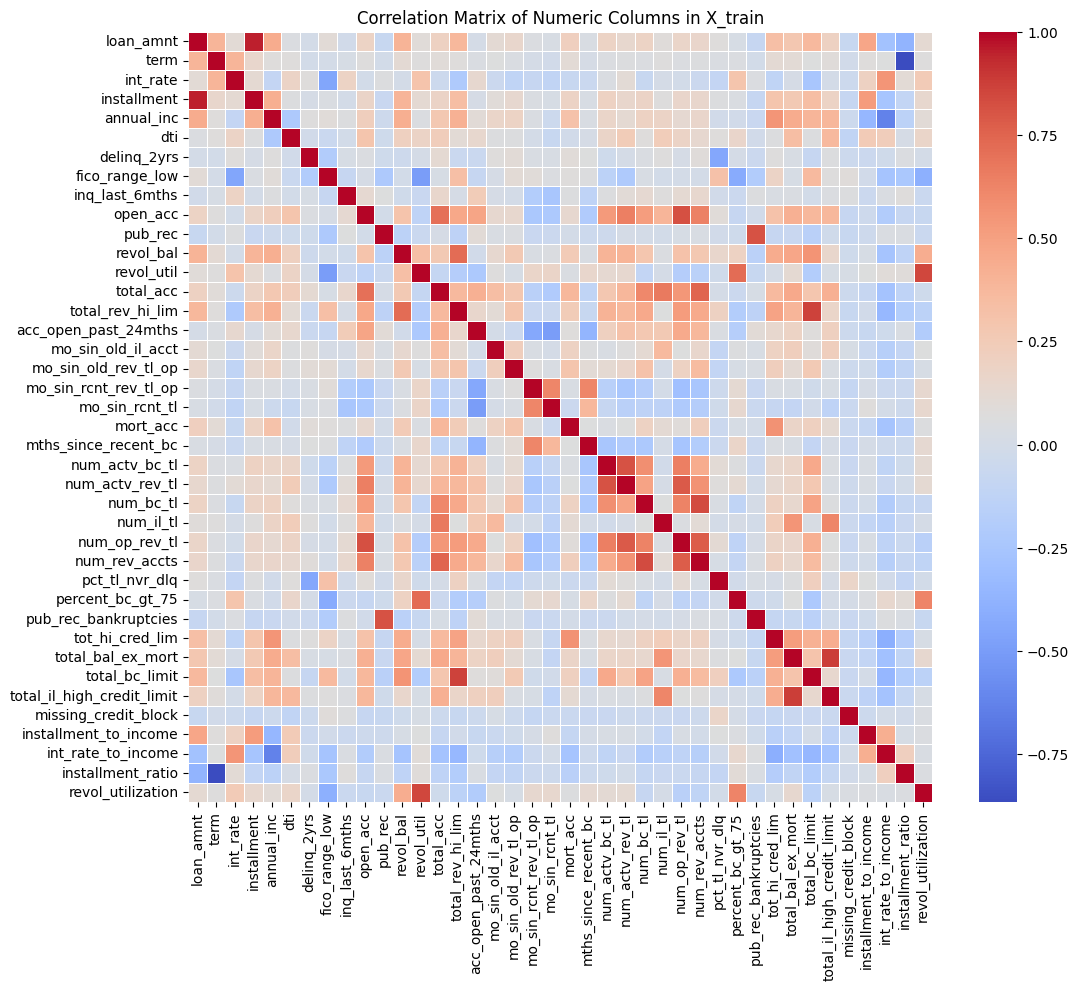

In [28]:
# Select only the numeric columns
X_train_numeric = X_train.select_dtypes(include=np.number)

# Compute correlation matrix for numeric columns
corr_matrix = X_train_numeric.corr()

# Plot heatmap
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix of Numeric Columns in X_train")
plt.show()

In [29]:
# Select only the numeric columns from the preprocessed training data
X_train_numeric = X_train.select_dtypes(include=np.number)

# Calculate VIF for each feature
# Add a constant to the dataframe to calculate VIF for the intercept
X_train_numeric_constant = sm.add_constant(X_train_numeric)

vif_values = [variance_inflation_factor(X_train_numeric_constant.values, i)
                   for i in range(X_train_numeric_constant.shape[1])]

# Create the VIF DataFrame after calculating all VIFs
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_numeric_constant.columns
vif_data["VIF"] = vif_values

# Drop the VIF for the constant term, as it's not informative
vif_data = vif_data[vif_data['feature'] != 'const']

# Sort by VIF in descending order
vif_data = vif_data.sort_values(by="VIF", ascending=False)

print("Variance Inflation Factor (VIF) for X_train:")
display(vif_data)

Variance Inflation Factor (VIF) for X_train:


,feature,VIF
2,term,67.758019
39,installment_ratio,63.076602
1,loan_amnt,58.404038
4,installment,55.321844
3,int_rate,19.735351
14,total_acc,18.965799
28,num_rev_accts,16.466937
15,total_rev_hi_lim,12.617670
33,total_bal_ex_mort,11.296631
35,total_il_high_credit_limit,11.160150


In [31]:
# List of columns to drop
binned_cols = ['annual_inc', 'fico_range_low', 'revol_bal', 'installment', 'pub_rec', 'open_acc', 'installment_ratio', 'total_rev_hi_lim', 'total_bal_ex_mort', 'num_op_rev_tl' ]

# Drop from all dataset splits
X_train = X_train.drop(columns=binned_cols, errors='ignore')
X_val = X_val.drop(columns=binned_cols, errors='ignore')
X_test = X_test.drop(columns=binned_cols, errors='ignore')

**Convert floats to intergers**

In [34]:
# List of integer / count features
int_features = [
    'open_acc',
    'pub_rec',
    'total_acc',
    'term',
    'inq_last_6mths',
    'acc_now_delinq',
    'acc_open_past_24mths',
    'delinq_2yrs',
    ' mort_acc',
    'loan_amnt',
    'num_rev_accts',
    'pub_rec_bankruptcies',
    'num_bc_tl'
    'num_rev_accts',
    'num_bc_tl'
]

def convert_to_int(X, features):
    for col in features:
        if col in X.columns:
            X[col] = X[col].astype(int)
    return X

# Apply to all datasets
X_train = convert_to_int(X_train, int_features)
X_val   = convert_to_int(X_val, int_features)
X_test  = convert_to_int(X_test, int_features)

print("✅ Integer features converted from float to int in all datasets.")

✅ Integer features converted from float to int in all datasets.


In [35]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 223295 entries, 64988 to 110931
Data columns (total 40 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   loan_amnt                   223295 non-null  int64   
 1   term                        223295 non-null  int64   
 2   int_rate                    223295 non-null  float64 
 3   grade                       223295 non-null  object  
 4   emp_length                  223295 non-null  object  
 5   home_ownership              223295 non-null  object  
 6   verification_status         223295 non-null  object  
 7   purpose                     223295 non-null  object  
 8   dti                         223295 non-null  float64 
 9   delinq_2yrs                 223295 non-null  int64   
 10  inq_last_6mths              223295 non-null  int64   
 11  revol_util                  223295 non-null  float64 
 12  total_acc                   223295 non-null  int64   
 13  

_

## **5. ENCODING and NORMALISATION**

In [36]:
# -----------------------------
# 1️⃣ Identify columns
# -----------------------------
# Numeric columns: all numbers
numeric_cols = X_train.select_dtypes(include=np.number).columns.tolist()

# Categorical columns: object or category (including binned columns)
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Remove 'grade' for ordinal encoding
if 'grade' in categorical_cols:
    categorical_cols.remove('grade')
    ordinal_cols = ['grade']
else:
    ordinal_cols = []

# Define grade order
grade_order = [['A', 'B', 'C', 'D', 'E', 'F', 'G']]

# -----------------------------
# 2️⃣ ColumnTransformer for encoding + scaling
# -----------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
        ('ord', OrdinalEncoder(categories=grade_order), ordinal_cols)
    ],
    remainder='drop'
)

# -----------------------------
# 3️⃣ Fit & Transform
# -----------------------------
X_train_transformed = preprocessor.fit_transform(X_train)
X_val_transformed   = preprocessor.transform(X_val)
X_test_transformed  = preprocessor.transform(X_test)

# -----------------------------
# 4️⃣ Restore feature names
# -----------------------------
def get_feature_names(column_transformer):
    feature_names = []
    for name, transformer, columns in column_transformer.transformers_:
        if name == 'remainder' and transformer == 'drop':
            continue
        if hasattr(transformer, 'get_feature_names_out'):
            names = transformer.get_feature_names_out(columns)
            feature_names.extend(names)
        else:
            feature_names.extend(columns)
    return feature_names

feature_names = get_feature_names(preprocessor)

X_train = pd.DataFrame(X_train_transformed, columns=feature_names)
X_val   = pd.DataFrame(X_val_transformed, columns=feature_names)
X_test  = pd.DataFrame(X_test_transformed, columns=feature_names)

print("✅ Encoding and scaling complete. Feature names preserved.")
print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}, X_test shape: {X_test.shape}")


✅ Encoding and scaling complete. Feature names preserved.
X_train shape: (223295, 69), X_val shape: (31899, 69), X_test shape: (63799, 69)


In [37]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223295 entries, 0 to 223294
Data columns (total 69 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   loan_amnt                            223295 non-null  float64
 1   term                                 223295 non-null  float64
 2   int_rate                             223295 non-null  float64
 3   dti                                  223295 non-null  float64
 4   delinq_2yrs                          223295 non-null  float64
 5   inq_last_6mths                       223295 non-null  float64
 6   revol_util                           223295 non-null  float64
 7   total_acc                            223295 non-null  float64
 8   acc_open_past_24mths                 223295 non-null  float64
 9   mo_sin_old_il_acct                   223295 non-null  float64
 10  mo_sin_old_rev_tl_op                 223295 non-null  float64
 11  mo_sin_rcnt_r

_

## **6. CLASS IMBALANCE**

In [43]:
# Create copies to keep original datasets intact
X_train_copy = X_train.copy()
y_train_copy = y_train.copy()

In [46]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

def evaluate_model_xgb(X_train, y_train, X_val, y_val, sampling_method=None):
    """
    Evaluates an XGBoost model with different class imbalance handling methods.
    sampling_method: None, 'over', 'under', 'smote', or 'scale_pos_weight'
    """
    X_train_eval = X_train.copy()
    y_train_eval = y_train.copy()

    if sampling_method == 'over':
        ros = RandomOverSampler(random_state=42)
        X_train_eval, y_train_eval = ros.fit_resample(X_train_eval, y_train_eval)
    elif sampling_method == 'under':
        rus = RandomUnderSampler(random_state=42)
        X_train_eval, y_train_eval = rus.fit_resample(X_train_eval, y_train_eval)
    elif sampling_method == 'smote':
        sm = SMOTE(random_state=42)
        X_train_eval, y_train_eval = sm.fit_resample(X_train_eval, y_train_eval)

    # XGBoost Classifier
    if sampling_method == 'scale_pos_weight':
        # Calculate scale_pos_weight for balanced classes
        scale_pos_weight_value = sum(y_train_eval == 0) / sum(y_train_eval == 1)
        model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, scale_pos_weight=scale_pos_weight_value)
    else:
        model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

    model.fit(X_train_eval, y_train_eval)

    y_pred      = model.predict(X_val)
    y_pred_prob = model.predict_proba(X_val)[:,1]

    return {
        'sampling': sampling_method,
        'roc_auc': roc_auc_score(y_val, y_pred_prob),
        'recall': recall_score(y_val, y_pred),
        'precision': precision_score(y_val, y_pred),
        'f1': f1_score(y_val, y_pred),
        'accuracy': accuracy_score(y_val, y_pred)
    }

In [47]:
methods = ['class_weight', 'over', 'under', 'smote', None]
results = []

for method in methods:
    res = evaluate_model(X_train_copy, y_train_copy, X_val, y_val, sampling_method=method)
    results.append(res)

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='roc_auc', ascending=False).reset_index(drop=True)
print(results_df)


       sampling   roc_auc    recall  precision        f1  accuracy
0  class_weight  0.707278  0.635241   0.314395  0.420617  0.657826
1          over  0.707175  0.634921   0.313688  0.419914  0.657011
2          None  0.707055  0.074074   0.525000  0.129830  0.805856
3         under  0.706839  0.635562   0.313583  0.419960  0.656729
4         smote  0.701953  0.627706   0.310001  0.415032  0.654033


_

### **7. PCA**

In [ ]:
# PCA on copies of the datasets
X_train_pca = X_train.copy()
X_val_pca   = X_val.copy()
X_test_pca  = X_test.copy()


In [ ]:
from sklearn.decomposition import PCA

# Initialize PCA (95% variance)
pca = PCA(n_components=0.95, random_state=42)

# Fit on copy of X_train
X_train_pca = pca.fit_transform(X_train_pca)
X_val_pca   = pca.transform(X_val_pca)
X_test_pca  = pca.transform(X_test_pca)

# DataFrames with PC names
pc_names = [f'PC{i+1}' for i in range(X_train_pca.shape[1])]
X_train_pca = pd.DataFrame(X_train_pca, columns=pc_names)
X_val_pca   = pd.DataFrame(X_val_pca, columns=pc_names)



Explained variance ratio of each component:
[0.14766434 0.12547188 0.09445275 0.06734628 0.05152407 0.04061228
 0.03796488 0.03572911 0.0317603  0.02876391 0.02428115 0.02321686
 0.02184433 0.01927138 0.01608762 0.01488479 0.0136474  0.01293976
 0.0125577  0.01237229 0.01205746 0.01040241 0.00958806 0.00905667
 0.00860214 0.0084697  0.00764134 0.00726768 0.00674001 0.00566103
 0.00550488 0.00524684 0.00497173 0.00484942 0.00466441 0.00458833
 0.00403615]

Cumulative explained variance:
[0.14766434 0.27313622 0.36758898 0.43493526 0.48645933 0.52707161
 0.56503649 0.6007656  0.6325259  0.66128981 0.68557096 0.70878782
 0.73063215 0.74990353 0.76599115 0.78087594 0.79452335 0.80746311
 0.8200208  0.83239309 0.84445055 0.85485296 0.86444102 0.87349768
 0.88209983 0.89056953 0.89821087 0.90547855 0.91221855 0.91787958
 0.92338446 0.9286313  0.93360303 0.93845245 0.94311686 0.94770519
 0.95174134]


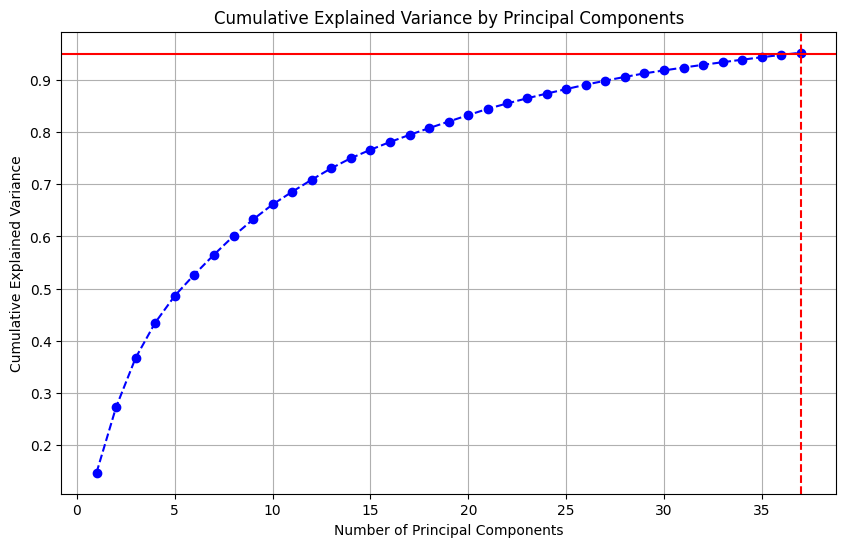

In [ ]:
# 1️⃣ Explained variance ratio
explained_var_ratio = pca.explained_variance_ratio_
print("Explained variance ratio of each component:")
print(explained_var_ratio)

# 2️⃣ Cumulative explained variance
cumulative_var = np.cumsum(explained_var_ratio)
print("\nCumulative explained variance:")
print(cumulative_var)

# 3️⃣ Plot
plt.figure(figsize=(10,6))
plt.plot(range(1, len(cumulative_var)+1), cumulative_var, marker='o', linestyle='--', color='b')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='-')  # 95% variance line
plt.axvline(x=np.argmax(cumulative_var >= 0.95)+1, color='r', linestyle='--')  # PC count to reach 95%
plt.show()


**Test using logistic regression model**

In [ ]:

# -----------------------------
# 1️⃣ Initialize model
# -----------------------------
# Use class_weight='balanced' to handle imbalance
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# -----------------------------
# 2️⃣ Fit model
# -----------------------------
logreg.fit(X_train_pca, y_train)  # assuming y_train is your target

# -----------------------------
# 3️⃣ Predict on validation set
# -----------------------------
y_val_pred       = logreg.predict(X_val_pca)
y_val_pred_prob  = logreg.predict_proba(X_val_pca)[:,1]

# -----------------------------
# 4️⃣ Evaluate
# -----------------------------
roc_auc   = roc_auc_score(y_val, y_val_pred_prob)
recall    = recall_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
f1        = f1_score(y_val, y_val_pred)
accuracy  = accuracy_score(y_val, y_val_pred)

# -----------------------------
# 5️⃣ Print results
# -----------------------------
print("Logistic Regression Performance on PCA Data (Validation Set):")
print(f"ROC AUC   : {roc_auc:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"Precision : {precision:.4f}")
print(f"F1-score  : {f1:.4f}")
print(f"Accuracy  : {accuracy:.4f}")


Logistic Regression Performance on PCA Data (Validation Set):
ROC AUC   : 0.7041
Recall    : 0.6316
Precision : 0.3141
F1-score  : 0.4196
Accuracy  : 0.6583


In [ ]:
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# -----------------------------
# 2️⃣ Fit model on preprocessed data (not PCA)
# -----------------------------
logreg.fit(X_train, y_train)

# -----------------------------
# 3️⃣ Predict on validation set
# -----------------------------
y_val_pred      = logreg.predict(X_val)
y_val_pred_prob = logreg.predict_proba(X_val)[:,1]

# -----------------------------
# 4️⃣ Evaluate
# -----------------------------
roc_auc   = roc_auc_score(y_val, y_val_pred_prob)
recall    = recall_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
f1        = f1_score(y_val, y_val_pred)
accuracy  = accuracy_score(y_val, y_val_pred)

# -----------------------------
# 5️⃣ Print results
# -----------------------------
print("Logistic Regression Performance on Original Preprocessed Data (Validation Set):")
print(f"ROC AUC   : {roc_auc:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"Precision : {precision:.4f}")
print(f"F1-score  : {f1:.4f}")
print(f"Accuracy  : {accuracy:.4f}")

Logistic Regression Performance on Original Preprocessed Data (Validation Set):
ROC AUC   : 0.7073
Recall    : 0.6352
Precision : 0.3144
F1-score  : 0.4206
Accuracy  : 0.6578


_

## **8. FEATURE SELECTION**

In [53]:
# Fit a simple XGBoost model on the training data
xgb_model = XGBClassifier(
    random_state=42,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='auc'
)

# Add the clean_feature_names function
import re
def clean_feature_names(df):
    """Cleans column names to be compatible with XGBoost."""
    cols = df.columns
    new_cols = []
    for col in cols:
        # Replace invalid characters with underscores or remove them
        new_col = re.sub(r'\[|\]|<', '_', col) # Replace [, ], < with _
        new_col = re.sub(r'[^A-Za-z0-9_]+', '', new_col) # Remove other special characters
        new_cols.append(new_col)
    df.columns = new_cols
    return df

# Clean feature names in X_train before fitting the model
X_train_cleaned = clean_feature_names(X_train.copy())

xgb_model.fit(X_train_cleaned, y_train)

# Get feature importances
importances = xgb_model.feature_importances_
features = np.array(X_train_cleaned.columns) # Use cleaned column names

# Create a DataFrame of features and their importance
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Display top 50 most important features
top_n = 50
important_features = feature_importances.head(top_n)

print(f"Top {top_n} Important Features:")
display(important_features)

# Store them as a list for reuse later
top_features = important_features['Feature'].tolist()

Top 50 Important Features:


,Feature,Importance
0,grade,0.401302
1,int_rate,0.058903
2,term,0.044665
3,mort_acc,0.021550
4,emp_length_unknown,0.021327
5,home_ownership_MORTGAGE,0.020167
6,installment_to_income,0.017570
7,home_ownership_RENT,0.015789
8,acc_open_past_24mths,0.015048
9,region_West,0.013236


In [54]:
X_train_fs = X_train.copy()
X_val_fs = X_val.copy()
X_test_fs = X_test.copy()


In [59]:
# Suppose 'top_features' is your ordered list of feature names by importance
top_37_features = top_features[:37] # Changed from 30 to 37

# Add the clean_feature_names function (if not already in this cell)
import re
def clean_feature_names(df):
    """Cleans column names to be compatible with XGBoost and pandas indexing."""
    cols = df.columns
    new_cols = []
    for col in cols:
        # Replace invalid characters with underscores or remove them
        new_col = re.sub(r'\[|\]|<', '_', col) # Replace [, ], < with _
        new_col = re.sub(r'[^A-Za-z0-9_]+', '', new_col) # Remove other special characters
        new_cols.append(new_col)
    df.columns = new_cols
    return df

# Clean feature names in the DataFrames before selecting features
# This ensures consistency with the 'top_features' list generated from a cleaned X_train
X_train_fs = clean_feature_names(X_train.copy()) # Start with original X_train
X_val_fs = clean_feature_names(X_val.copy())     # Start with original X_val
X_test_fs = clean_feature_names(X_test.copy())   # Start with original X_test


X_train_fs = X_train_fs[top_37_features]
X_val_fs = X_val_fs[top_37_features]
X_test_fs = X_test_fs[top_37_features]

print("✅ Feature selection applied. Datasets now contain only the top 37 features.")
print(f"X_train_fs shape: {X_train_fs.shape}")
print(f"X_val_fs shape: {X_val_fs.shape}")
print(f"X_test_fs shape: {X_test_fs.shape}")

✅ Feature selection applied. Datasets now contain only the top 37 features.
X_train_fs shape: (223295, 37)
X_val_fs shape: (31899, 37)
X_test_fs shape: (63799, 37)


In [60]:
model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model.fit(X_train_fs, y_train)

y_pred = model.predict(X_val_fs)
y_prob = model.predict_proba(X_val_fs)[:, 1]

print("Logistic Regression Performance (Top 30 Features)")
print("ROC AUC   :", roc_auc_score(y_val, y_prob))
print("Recall    :", recall_score(y_val, y_pred))
print("Precision :", precision_score(y_val, y_pred))
print("F1-score  :", f1_score(y_val, y_pred))
print("Accuracy  :", accuracy_score(y_val, y_pred))


Logistic Regression Performance (Top 30 Features)
ROC AUC   : 0.7066720288604786
Recall    : 0.6334776334776335
Precision : 0.3144699140401146
F1-score  : 0.4202967927237913
Accuracy  : 0.6583278472679395


_

**Save Data**

In [65]:
X_train.head()

,loan_amnt,term,int_rate,dti,delinq_2yrs,inq_last_6mths,revol_util,total_acc,acc_open_past_24mths,mo_sin_old_il_acct,...,region_SouthWest,region_West,annual_inc_bin_High,annual_inc_bin_Low,annual_inc_bin_Medium,annual_inc_bin_Very Low,revol_util_bin_Very Low,fico_bin_High,fico_bin_Medium,grade
0,-0.200000,0.0,0.232595,0.402587,0.0,3.0,0.053846,0.266667,0.00,0.00,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,3.0
1,-0.166667,0.0,0.172468,-0.477769,0.0,3.0,-1.176923,1.333333,0.25,0.38,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,2.0
2,-0.600000,0.0,0.479430,1.282134,0.0,0.0,-0.674359,-0.533333,1.25,-2.16,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,2.0
3,-0.750000,0.0,1.723101,0.568310,0.0,0.0,0.869231,-0.666667,0.75,-0.02,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,4.0
4,2.333333,0.0,-0.759494,-0.421989,0.0,1.0,0.341026,0.266667,-0.50,0.34,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [68]:
# --- 1️⃣ Define top 37 features ---
top_37_features = top_features[:37]  # assuming top_features is your ordered importance list

# Add the clean_feature_names function (if not already defined)
import re
def clean_feature_names(df):
    """Cleans column names to be compatible with pandas indexing."""
    cols = df.columns
    new_cols = []
    for col in cols:
        # Replace invalid characters with underscores or remove them
        new_col = re.sub(r'\[|\]|<', '_', col) # Replace [, ], < with _
        new_col = re.sub(r'[^A-Za-z0-9_]+', '', new_col) # Remove other special characters
        new_cols.append(new_col)
    df.columns = new_cols
    return df

# --- Apply cleaning to the DataFrames ---
X_train_cleaned = clean_feature_names(X_train.copy())
X_val_cleaned = clean_feature_names(X_val.copy())
X_test_cleaned = clean_feature_names(X_test.copy())


# --- 2️⃣ Subset train, val, test using the cleaned DataFrames ---
X_train_fs = X_train_cleaned[top_37_features].copy()
X_val_fs   = X_val_cleaned[top_37_features].copy()
X_test_fs  = X_test_cleaned[top_37_features].copy()

# Keep target variable
y_train_fs = y_train.copy()
y_val_fs   = y_val.copy()
y_test_fs  = y_test.copy()

# --- 3️⃣ Merge train + val for full training set ---
X_full_train = pd.concat([X_train_fs, X_val_fs], axis=0).reset_index(drop=True)
y_full_train = pd.concat([y_train_fs, y_val_fs], axis=0).reset_index(drop=True)

# Combine features + target for saving
full_train_set = pd.concat([X_full_train, y_full_train], axis=1)
test_set       = pd.concat([X_test_fs, y_test_fs], axis=1)

# --- 4️⃣ Save CSVs to Google Drive ---
save_path = "/content/drive/MyDrive/split_P2_data/"
os.makedirs(save_path, exist_ok=True) # Create the directory if it doesn't exist

full_train_set.to_csv(save_path + "full_train_set.csv", index=False)
test_set.to_csv(save_path + "test_set.csv", index=False)

print("✅ Full train set shape:", full_train_set.shape)
print("✅ Test set shape:", test_set.shape)
print(f"✅ CSVs saved to: {save_path}'full_train_set.csv' and '{save_path}test_set.csv'")

✅ Full train set shape: (255194, 38)
✅ Test set shape: (114845, 38)
✅ CSVs saved to: /content/drive/MyDrive/split_P2_data/'full_train_set.csv' and '/content/drive/MyDrive/split_P2_data/test_set.csv'


_

**NEXT COLLAB NOTEBOOK**